<a href="https://colab.research.google.com/github/Suaif/Video_descriptor/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0. Import of our own module.

Throughout the project we have found that many of the functions occupy a large part of the project, making the code invisible and disorganizing it in some way..Therefore, we have created a separate document where all the functions that we will use will be, we will import this document as a new module, this way we will have access to these functions without them appearing explicitly in the main document.


`*Import OurOwnFunctions.ipynb with all the functions.*`

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!git clone https://github.com/Suaif/Video_descriptor

Cloning into 'Video_descriptor'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 64 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [15]:
%cd '/content/Video_descriptor/'

/content/Video_descriptor


In [16]:
!pip install import-ipynb

In [17]:
import import_ipynb
import OurOwnFunctions

# Step 1. Cleaning and generating our dataset


After some researh we decided to use the MSVD  Dataset, it is made of 1970 YouYube videos each one with different descriptions in different languages.

*  [`MSVD Dataset`](http://www.cs.utexas.edu/users/ml/clamp/videoDescription/)


The original dataset contained descriptions in several languages, we are interested only in the descriptions made in English. So, in the following code cells we will filter the dataset, saving only and exclusively the data in English.


---


**Problems found:**

*  The dataset has different descriptions in the same language for the same video, we decided to use the first English description for each video. Maybe in the future different descriptions could be used for the same video.
*  The dataset contains video names that do not match some of the video names we have. Therefore, we've removed those descriptions whose videos we didn't have.
* Once filtered we realized that the internal 'index' of the dataSet was skipped, we needed to reset the index. 


---




In [18]:
import pandas as pd
import numpy as np

In [ ]:
# --- Cleaning dataset.
#   * Select only the English language rows.
#   * Delete the following columns: [WorkerID, Language, Source]
#   * Remove duplicated rows for the same [VideoId]
#   * Create new column [VideoName] with following format: [VideoId_Start_End]

csv_path = "/content/Video_descriptor/video_corpus.csv"
data = pd.read_csv(csv_path)

dataSet = data[data['Language'] == 'English']
dataSet = dataSet.drop(['WorkerID', 'Language', 'Source'], axis=1)
dataSet = dataSet.drop_duplicates(['VideoID'])

dataSet['VideoName'] = dataSet[['VideoID','Start','End']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
dataSet.head()

VideoID  ...            VideoName
18   mv89psg6zh4  ...    mv89psg6zh4_33_46
56   ZbzDGXEwtGc  ...     ZbzDGXEwtGc_6_15
125  jbzaMtPYtl8  ...    jbzaMtPYtl8_48_58
176  g36ho6UrBz0  ...     g36ho6UrBz0_5_20
251  04Gt01vatkk  ...  04Gt01vatkk_248_265

[5 rows x 6 columns]

In [ ]:
import os

# --- Cleaning Dataset of non existing videos.
#   * We check that the route of the video exist, generating a list of those that do not.
#   * We delete the rows of non existing videos.
#   * We clean the Dataset of unnecessary columns [Start, End, AnnotationTime]
#   * We save the new clean Dataset.

#   * Ipath: Filepath where we have all the videos.

Ipath = '/content/drive/My Drive/Proyecto final/MSVD/YouTubeClips/'

# -- Get the name of the non existing videos.
name_videosNOTexisting = [ nameV for nameV in dataSet['VideoName'] 
                             if not os.path.exists(Ipath + nameV + '.avi') ]

# -- Remove rows of videos that do not exist.
for videoName in name_videosNOTexisting:
  dataSet.drop(dataSet[dataSet.VideoName == videoName].index , inplace=True)

# -- Get the new dataset
newcorpus = dataSet.drop(['Start', 'End', 'AnnotationTime'], axis=1)
newcorpus.reset_index(inplace=True, drop=True)

# --- Cleaning the format of the descriptions
i=0
count = 0
for ID in newcorpus['VideoName']:
  avi = ID + ".avi"
  for videoname in os.listdir(Ipath):
    if videoname == avi:
      newcorpus['Description'][i] = OurOwnFunctions.clean_text(newcorpus['Description'][i])
      i +=1

newcorpus.head()

VideoID  ...            VideoName
0  mv89psg6zh4  ...    mv89psg6zh4_33_46
1  ZbzDGXEwtGc  ...     ZbzDGXEwtGc_6_15
2  jbzaMtPYtl8  ...    jbzaMtPYtl8_48_58
3  g36ho6UrBz0  ...     g36ho6UrBz0_5_20
4  04Gt01vatkk  ...  04Gt01vatkk_248_265

[5 rows x 3 columns]

# Step 2. Model creation 

This will be the structure of our model:

* First we'll analyze the sequence of video frames using VGG16 Model and a LSTM layer. This will produce two internal states vectors

* This vectors will be given to the LSTM encoder along with the video description after being processed by the Embedding layer. 

* The ouput description will be one timestep ahead of the input description, this is because we want the model to predict next word.

* The predicted word will be given in One-Hot encoding so in the last Dense layer we'll need as many neurons as words in our vocabulary.



  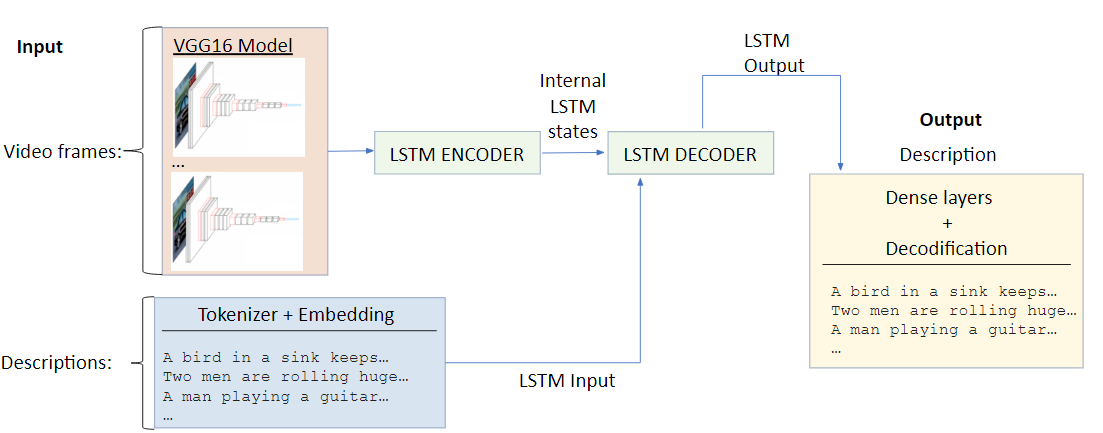

## VGG Model

To use a pre-trained model like VGG16 will help us to better analyze and process our frames. Also the main model will learn faster.

In [19]:
from tensorflow.keras.applications import vgg16

def create_vgg16():  
  model = vgg16.VGG16(include_top=True, 
                      weights="imagenet", 
                      input_tensor=None, 
                      input_shape=None, 
                      pooling=None, 
                      classes=1000)
                      #classifier_activation="softmax")
  return model

vgg16_model = create_vgg16() 

## Tokenizer creation

In order to work better with the words we'll tokenize our descriptions.

Besides, we'll add two special characters, one at beggining (BOS-Beginning of secuence) and one at the end (EOS-End of secuence) of each description, so the model can learn to predict the end of a secuence.

In [ ]:
# --- Adding the special characters

newcorpus['Target Description'] = np.nan

for i in range(newcorpus.shape[0]):

  newcorpus['Target Description'][i] = ((str("<BOS>") + str(" ") + newcorpus['Description'][i] + str(" ") + str("<EOS>")))

# -- Save the new dataset
newcorpus.to_csv('/content/drive/My Drive/proyecto final/newcorpus.csv', index=False)
newcorpus.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


VideoID  ...                                 Target Description
0  mv89psg6zh4  ...  <BOS> a bird in a sink keeps getting under the...
1  ZbzDGXEwtGc  ...              <BOS> a plane flying in the sky <EOS>
2  jbzaMtPYtl8  ...  <BOS> two men are rolling huge tires sideways ...
3  g36ho6UrBz0  ...  <BOS> a man playing a guitar outside his house...
4  04Gt01vatkk  ...                   <BOS> a woman cuts an oion <EOS>

[5 rows x 4 columns]

In [20]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

data = pd.read_csv("/content/drive/My Drive/proyecto final/newcorpus.csv")

n_descriptions = data.shape[0] #Number of descriptions we have

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Target Description'])
word_index = tokenizer.word_index

max_sentence_len = max([len(i.split()) for i in data['Target Description']])

print(n_descriptions, len(word_index), max_sentence_len)

1491 2059 42


## Embeddings

To get a better word association we will use an embeddings layer

In [21]:
#We will use the pre-trained model of GloVe embeddings, it can be downloaded at: https://nlp.stanford.edu/projects/glove/

import os
import numpy as np

embeddings_index = {}
f = open(os.path.join("/content/drive/My Drive/proyecto final/", 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [22]:
#We create the embedding matrix for our vocabulary

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [23]:
#Now we can create our Embeddings layer which we will include in our model

import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding((len(word_index)+1),
                            100,
                            weights=[embedding_matrix],
                            input_length=max_sentence_len, 
                            mask_zero = True,
                            trainable = True)

## Model

Now we can create and compile the main model

In [37]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

# --- Variables

n_frames = 5
height = 224 #(224, 224) because the VGG model is trained for this image size
width = 224 
learn = 0.00003
n_lstm = 64 #Number of units of the LSTM layer, both LSTM layers must have same number because we'll connect the internal states vectors


# --- Hidden vectors LSTM https://www.quora.com/How-is-the-hidden-state-h-different-from-the-memory-c-in-an-LSTM-cell
# --- Model: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

base_model = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer("flatten").output)
base_model.trainable = False #We won't train the VGG model
encoder_inputs = Input((n_frames,224,224,3)) #Input size: secuence of frames
x = TimeDistributed(base_model)(encoder_inputs) #Generar una secuencia temporal en la LSTM a partir del modelo VGG19
lstm_out, lstm_h, lstm_c = LSTM(n_lstm, input_shape=(n_frames, 1), activation='tanh', return_state=True)(x)
encoder_states = [lstm_h,lstm_c] 

''' Once the two hidden states (encoder_states) are concatenated in the same varaible, they will be used to 
inject it into the next LSTM layer and thus initialize it '''

decoder_inputs = Input(shape=(max_sentence_len)) #Input size: Maximum number of words in a description

decoder_Embedding = embedding_layer(decoder_inputs)

'''
  LSTM to decode.
    input:            description secuence of the video
    initial_states:   output of the LSTM encoder, it contains the information of the video analysis
'''

decoder_lstm = LSTM(n_lstm, return_sequences=True, return_state=True, activation='tanh')  
decoder_outputs, _, _ = decoder_lstm(decoder_Embedding, initial_state=encoder_states)

dense = Dense(128,activation='relu')(decoder_outputs)
dense = Dense(len(word_index)+1, activation='softmax')(dense)
decoder_outputs = dense

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(lr=learn), loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 5, 224, 224, 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 25088)     14714688    input_9[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 100)      206000      input_10[0][0]                   
______________________________________________________________________________________

# Step 3. How to pass the data to the model

We'll use generators to not overload the RAM memory

## Install the Video-Generators library.

This library will extract the frames from the videos.

In [24]:
pip install keras-video-generators

  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp36-none-any.whl size=12883 sha256=a749621ba604ffbb62512ee67d3943cefafb22d80b50c7114f5e829f38451cab
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


## VideoGenerator

We will create 3 generators, for train, validation and test.

In [38]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator

import pandas as pd
import numpy as np

# Some generator parameters
SIZE = (height, width)
CHANNELS = 3
NBFRAME = n_frames
BS = 1


# We have the videos with description in a folder named videos:

classes=['videos']

glob_pattern='/content/drive/My Drive/proyecto final/{classname}/*.avi'

# Create video frame generator
train = VideoFrameGenerator(
    glob_pattern=glob_pattern,
    classes = classes,
    nb_frames=NBFRAME,
    split_test=.3, 
    split_val=.3,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=False)

valid = train.get_validation_generator()

test = train.get_test_generator()


class videos, validation count: 447, test count: 313, train count: 731
Total data: 1 classes for 731 files for train
Total data: 1 classes for 447 files for validation
Total data: 1 classes for 313 files for test


## Generadores Custom

Video-generators only give us the frames, we need to create new generators in order to give the model the frames and also their descriptions.


The ouput descriptions have to be one timestep ahead so that the model learns to predict the next word. To make the dimensions fit, a 0 is added at the end of each description.

In [39]:
from keras_video.utils import *
from keras.utils import to_categorical


#--- Here we get the names of videos used by each generator

train_ids = [os.path.basename(path).split('.')[0] for path in train.files]
validation_ids = [os.path.basename(path).split('.')[0] for path in valid.files]


def train_generador(train_ids, train, data, tokenizer):

  #-- First we need to obtain the descriptions from the given video names
  Y_train = []
  for i in range(len(train_ids)):
    for j in range(n_descriptions):
      if train_ids[i] == data.values[j, 2]:
        Y_train.append(data.values[j, 3])

  Y_train = OurOwnFunctions.padding(tokenizer.texts_to_sequences(Y_train), max_sentence_len)
  Y_train = np.asarray(Y_train)
  Y_train = Y_train[None,:]

  i = 0
  train.next()[0]
  while 1:
    train_images = train.next()[0]/255.
    i +=1
    yield [train_images, Y_train[:,i,:max_sentence_len]], to_categorical(Y_train[:,i,1:], num_classes=len(word_index)+1)
    if i == (train.files_count-1):
      i=0


def validation_generador(validation_ids, valid, data, tokenizer):

  Y_validation = []
  for i in range(len(validation_ids)):
    for j in range(n_descriptions):  
      if validation_ids[i] == data.values[j, 2]:
        Y_validation.append(data.values[j, 3])

  Y_validation = OurOwnFunctions.padding(tokenizer.texts_to_sequences(Y_validation), max_sentence_len)
  Y_validation = np.asarray(Y_validation)
  Y_validation = Y_validation[None,:]

  i = 0
  valid.next()[0]
  while 1:
    validation_images = valid.next()[0]/255
    i+=1
    yield [validation_images, Y_validation[:,i,:max_sentence_len]],to_categorical(Y_validation[:,i,1:], num_classes=len(word_index)+1)
    if i==(valid.files_count-1):
      i=0

traingen = train_generador(train_ids, train, data, tokenizer)
validgen = validation_generador(validation_ids,valid,data, tokenizer)

# Step 4. Training

In [ ]:
#We can save the model each epoch

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/My Drive/Model91/",
    save_weights_only=False,
    monitor='val_loss',
    verbose=0,
    mode='min',
    save_best_only=True)

In [ ]:
'''
For the frames generated by the custom generators to be synchronized with the descriptions, 
it is necessary to run the VideoGenerator and Custom Generators cells every time before use model.fit 
'''

model.fit_generator(generator=traingen, validation_data=validgen, steps_per_epoch=(train.files_count-1), validation_steps=(valid.files_count-1), epochs=150, callbacks=[checkpoint_callback])

## Saving the model

In [ ]:
model_path = "/content/drive/My Drive/.../Model.h5"
model.save(model_path)

# Step 5. Let's predict!

## Loading a model

In [40]:
import tensorflow as tf

from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import numpy as np

model = tf.keras.models.load_model("/content/drive/My Drive/Copy of Adadelta.h5")

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 5, 224, 224, 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 25088)     14714688    input_5[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 100)      206000      input_6[0][0]                    
____________________________________________________________________________________________

## Encoder y Decoder

To make predictions we will need to create two sub-models from the main one.

**Encoder**

This sub-model gets the internal states vector after encoding the image sequence

In [41]:
encoder_model = Model(model.layers[0].input, [model.layers[4].output[1], model.layers[4].output[2]])
encoder_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5, 224, 224, 3)]  0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 25088)          14714688  
_________________________________________________________________
lstm_2 (LSTM)                [(None, 64), (None, 64),  6439168   
Total params: 21,153,856
Trainable params: 6,439,168
Non-trainable params: 14,714,688
_________________________________________________________________


**Decoder**

This sub-model will predict the next word of the one we give as an imput.

As input it'll have the states vector given by the encoder model and a word.

In [42]:
decoder_states_inputs =  [Input(shape=(n_lstm,)), Input(shape=(n_lstm,))]

decoder_outputs, state_h, state_c = model.layers[5](model.layers[3](model.input[1]), initial_state= decoder_states_inputs)

dense = model.layers[6](decoder_outputs)
decoder_outputs = model.layers[7](dense)

decoder_model = Model([model.layers[1].input] + decoder_states_inputs, 
                  [decoder_outputs] + [state_h, state_c])
decoder_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 100)      206000      input_6[0][0]                    
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 64)]         0                                            
______________________________________________________________________________________

## Predictions

In [43]:
#--- This new generator will give us a sequence of frames and their description

def test_generador(test_ids, test, data, tokenizer):

  Y_test = []
  for i in range(len(test_ids)):
    for j in range(n_descriptions):  
      if test_ids[i] == data[j, 2]:
        Y_test.append(data[j, 1])

  i = 0
  test.next()[0]
  while 1:
    test_images = test.next()[0]/255
    i+=1
    yield test_images, Y_test[i]
    if i==(test.files_count-1):
      i=0

data = pd.read_csv("/content/drive/My Drive/proyecto final/newcorpus.csv").values
test = train.get_test_generator()
test_ids = [os.path.basename(path).split('.')[0] for path in test.files]
testgen = test_generador(train_ids, train, data, tokenizer)

Total data: 1 classes for 313 files for test


----------
Original description: 
two men doing round house style kicks against each other
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


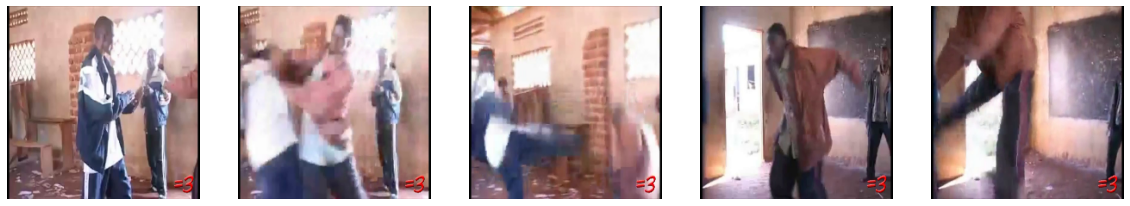

----------
Original description: 
a man is shooting at a target
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


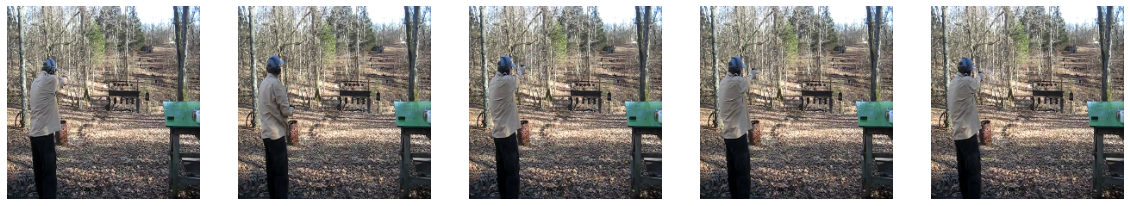

----------
Original description: 
garlic and pepper are being mixed
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


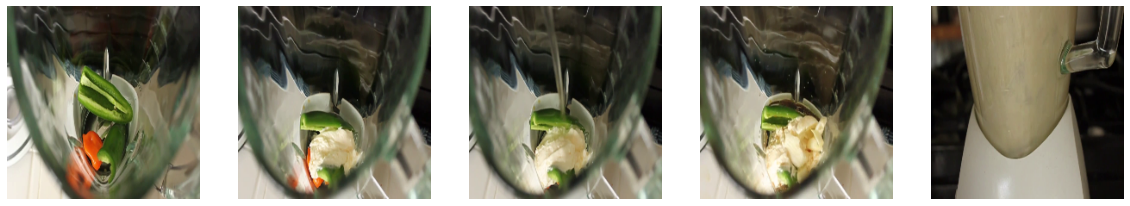

----------
Original description: 
a young man is being chased through the woods by three other young men
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


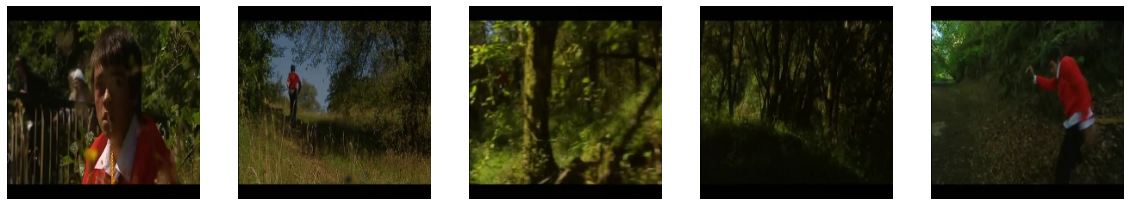

----------
Original description: 
a cat jumping into a box
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


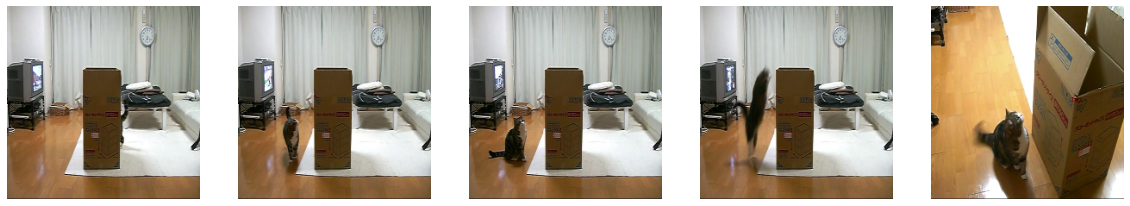

----------
Original description: 
the girl is using sign  language
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


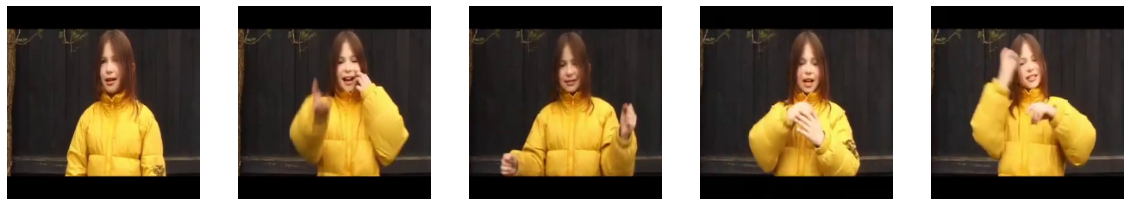

----------
Original description: 
a dog looking at himself in a mirror waves bites and barks at his image
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


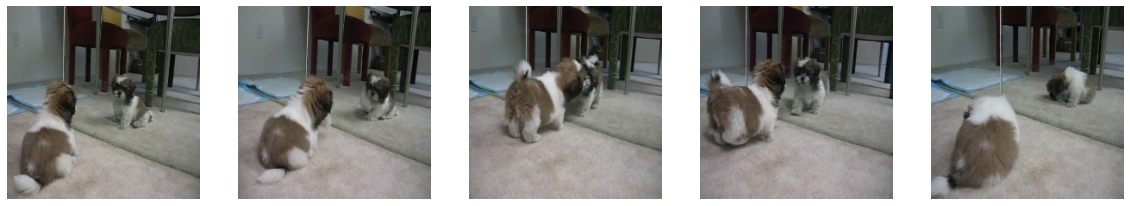

----------
Original description: 
jack nicholson is being patted down in a bathroom
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


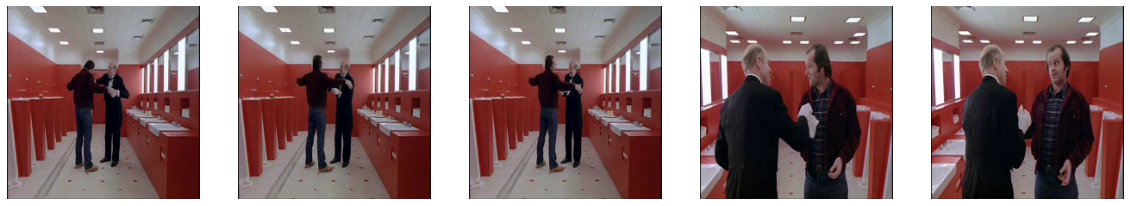

----------
Original description: 
a giant tortoise turns and walks away
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


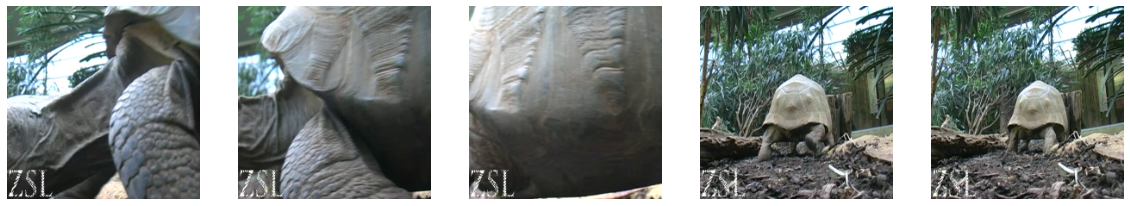

----------
Original description: 
a woman is taking a picture
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


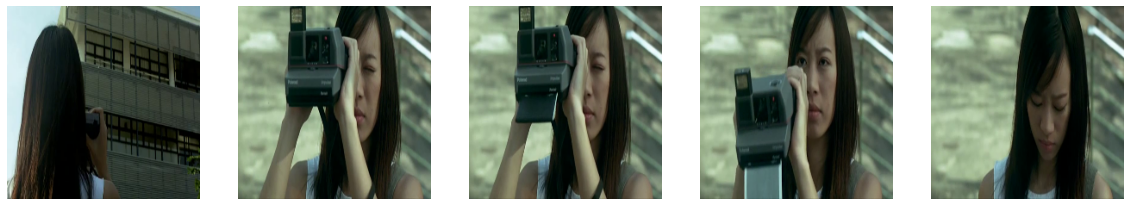

----------
Original description: 
a dog is moving through very deep snow by leaping forward and sinking repeatedly
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


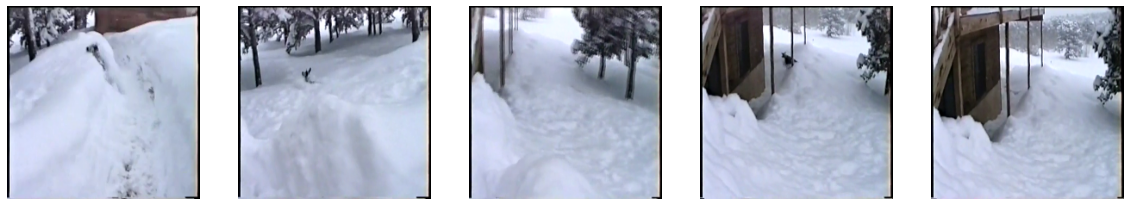

----------
Original description: 
a young man is playing the piano
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


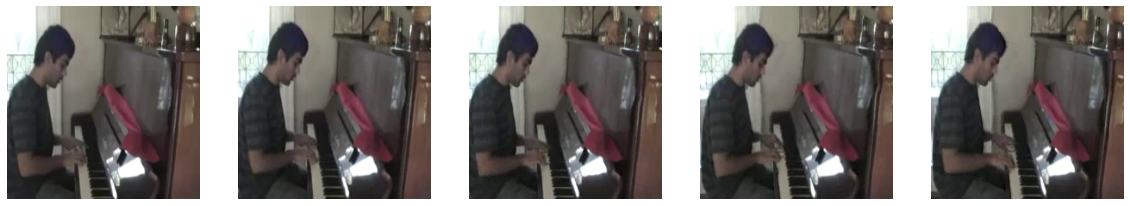

----------
Original description: 
a man is being treated for an emergency in a hospital
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


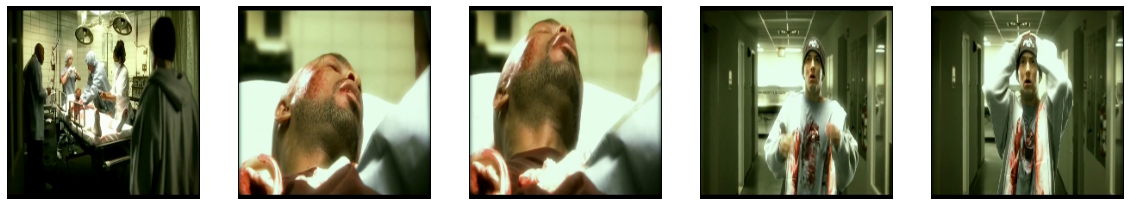

----------
Original description: 
a man is talking about a box of something he is holding up that he had pulled out of a larger corrugated cardboard box
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


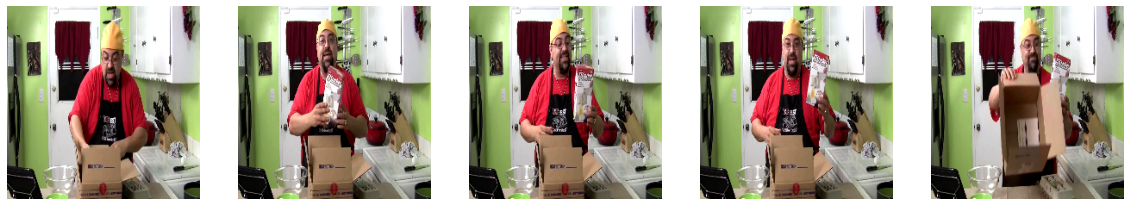

----------
Original description: 
a man dressed in commando clothes is firing from two guns held in both of his hands
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


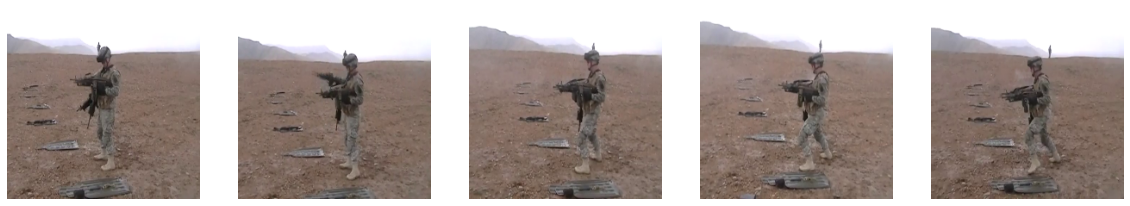

----------
Original description: 
two teams are playing basketball and a man on the white team makes a basket
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


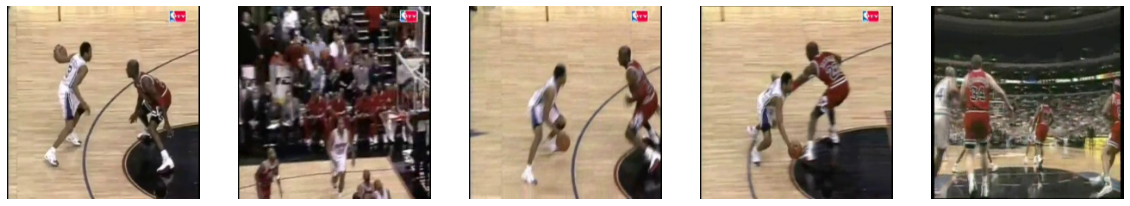

----------
Original description: 
a man and a woman are walking in the grass with their arms around each other
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


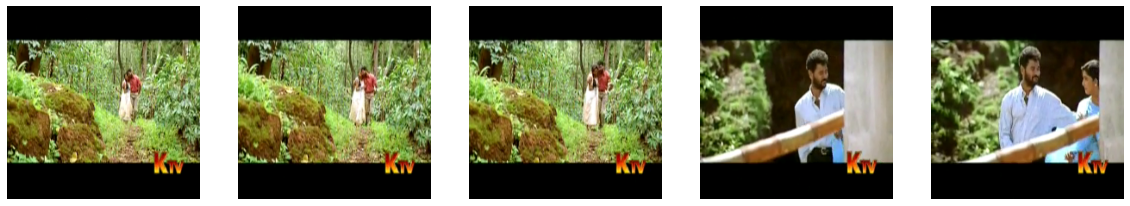

----------
Original description: 
a cat plays in a sink
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


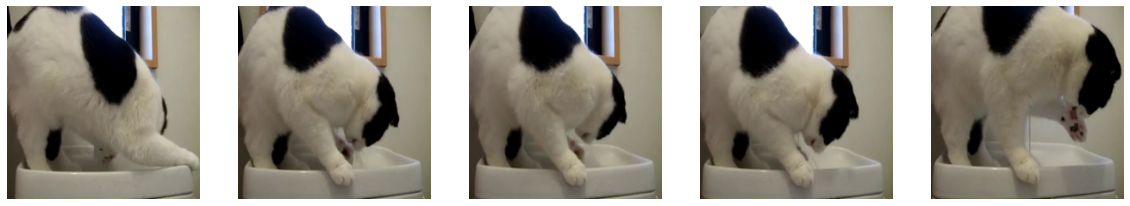

----------
Original description: 
a baby animal playing a persons hand
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


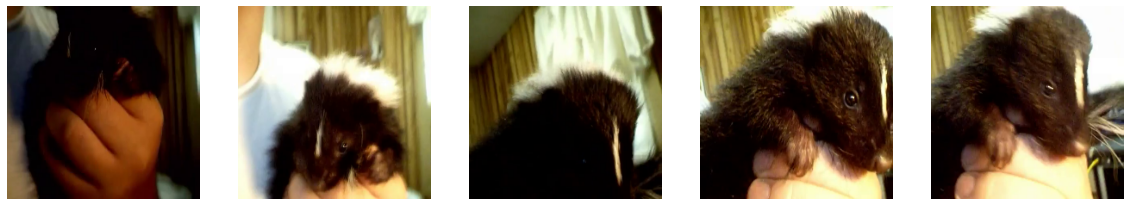

----------
Original description: 
a rhinoceros is grazing in the grass
Model description: 
['falling juggling cowboy cricket polishing background background rhinoceros sides carries folding racetrack racetrack racetrack racetrack kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite kite']


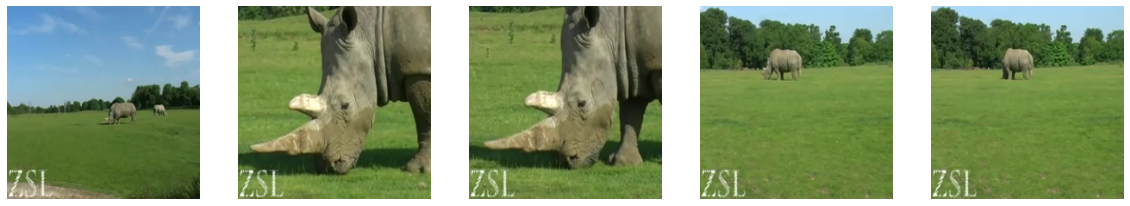

In [47]:
#Let's make some predictions:

for i in range(20):

  n = next(testgen)
  imgs = n[0]
  description = n[1]

  secuence = OurOwnFunctions.decode_sequence(imgs, encoder_model, decoder_model, max_sentence_len)
  p = OurOwnFunctions.int2str(secuence, tokenizer)

  print("----------")
  print("Original description: ")
  print(n[1])
  print("Model description: ")
  print(p)
  
  fig, axs = plt.subplots(1, n_frames, figsize=(20,20))

  for j in range(n_frames):
    axs[j].imshow(imgs[0,j]*255)
    axs[j].axis('off')

  plt.show()